# Introduction to Transfer Learning - The Intel Image Classification 

**Image Scene Classification of Multiclass**

This is image data of Natural Scenes around the world.

**Aim -** Try to build powerful Convolutional Neural Network(or use transfer learning) that can classify these images with more accuracy.

# Loading the data from Kaggle

You may need to use the Kaggle API token to load data into Google Colab environment.

**Note** - This is only for Google Colab users.

In [1]:
#!pip install kaggle

In [2]:
#!mkdir ~/.kaggle
#!cp /content/kaggle.json ~/.kaggle/kaggle.json
#!chmod 600 /root/.kaggle/kaggle.json

In [3]:
#!kaggle datasets download puneet6060/intel-image-classification

In [4]:
#!unzip *.zip

# Importing Libraries

In [5]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.offline import plot, iplot, init_notebook_mode
init_notebook_mode(connected=True)
sns.set_style(style = "darkgrid")
from keras.utils.vis_utils import plot_model

import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input 
from tensorflow.keras.applications.inception_v3 import preprocess_input as pre_in_incv3
from tensorflow.keras.applications.densenet import preprocess_input as pre_in_dne
from tensorflow.keras.applications.vgg16 import preprocess_input as pre_in_vgg

# Configurations

We configure the following things before modelling -



*   Define an Image Generator
*   Define the number of epochs
*   Define an optimizer
*   Define a learning rate
*   Define a graphing function




## Image Generator

This particular class helps us generate batches of tensor image data with real-time data augmentation.


The ImageDataGenerator class allows your model to receive new variations of the images at each epoch. 

Please refer to this informative article about the same at - https://towardsdatascience.com/image-data-augmentation-for-deep-learning-77a87fabd2bf


**Note -** Remember that it only returns the transformed images and does not add it to the set of images that you have.

In [6]:
image_generator = tf.keras.preprocessing.image.ImageDataGenerator()

# Dataset Properties

This Data contains around 25k images of size 150x150 distributed under 6 categories.


*   'buildings' -> 0
*   'forest' -> 1
*   'glacier' -> 2
*   'mountain' -> 3
*   'sea' -> 4
*   'street' -> 5


The Train, Test and Prediction data is separated in each zip files. There are around 14k images in Train, 3k in Test and 7k in Prediction.

This data was initially published on https://datahack.analyticsvidhya.com by 
Intel to host a Image classification Challenge.

In [7]:
# For Google Colab
#train_path = '/content/seg_train/seg_train'

# For Kaggle
train_path = '../input/intel-image-classification/seg_train/seg_train'

In [8]:
# For Google Colab
#test_path = '/content/seg_test/seg_test'

# For Kaggle
test_path = '../input/intel-image-classification/seg_test/seg_test'

Setting the Image Size as per our dataset.

In [9]:
image_size = 150

In [10]:
train_generator = image_generator.flow_from_directory(
        train_path,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical')

Found 14034 images belonging to 6 classes.


In [11]:
val_generator = image_generator.flow_from_directory(
        test_path,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical')

Found 3000 images belonging to 6 classes.


We will run each model for 10 epochs.

In [12]:
number_of_epochs = 10

In the dataset properties we have see that our dataset has a total of 6 classes.

In [13]:
number_of_classes = 6

## Charting function

We define a charting function to help, plot the model history and understand how accuracy and loss were during the epochs.

Everytime we run a model, the chart will include the current and previous to help us easily compare our models.

In [14]:
def graph_accuracy(history, number_of_epochs, model_name, fig=None, create_new_graph = False):
    accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    epochs = list(range(1, number_of_epochs+1))
    if create_new_graph == True and fig==None:
        fig = make_subplots(rows=1, cols=2,  subplot_titles=("Accuracy", "Validation Accuracy"))
        fig.add_trace(go.Scatter(x=epochs, y=accuracy, name= model_name),row=1, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=val_accuracy, name =model_name),row=1, col=2)
        fig.update_layout(height=400, width=1000)
    else:
        fig.add_trace(go.Scatter(x=epochs, y=accuracy, name= model_name),row=1, col=1)
        fig.add_trace(go.Scatter(x=epochs, y=val_accuracy, name = model_name),row=1, col=2)
    fig.show()
    return fig

## Scheduler Definition

We define a scheduler so that we can alter the learning rate as the epochs proceed.

In [15]:
def scheduler(epoch, lr):
    if epoch % 3 ==0:
        return lr*tf.math.exp(-0.1)
    else:
        return lr

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler, verbose=2)

# Defining a Baseline Convolutional Model

We define a simple CNN to see how it performs and then compare it to the list of SOTA Models.

In [16]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Conv2D(32, (3, 3), activation = 'relu', input_shape = (150, 150, 3)))
model.add(tf.keras.layers.Conv2D(32, (3, 3), strides = 2, activation = 'relu'))

model.add(tf.keras.layers.Conv2D(64, (3, 3), activation = 'relu'))
model.add(tf.keras.layers.Conv2D(64, (3, 3), strides = 2, activation = 'relu'))

model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(256, activation = 'relu'))
model.add(tf.keras.layers.Dense(number_of_classes, activation = 'softmax'))

**Model Summary**

A model summary is a very usefull method because be can better understand how the model works.

Summary also includes the amount of trainable and non-trainable parameters

We can also plot this summary to visualise the layers of the model.

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 73, 73, 32)        9248      
                                                                 
 conv2d_2 (Conv2D)           (None, 71, 71, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 35, 35, 64)        36928     
                                                                 
 flatten (Flatten)           (None, 78400)             0         
                                                                 
 dense (Dense)               (None, 256)               20070656  
                                                                 
 dense_1 (Dense)             (None, 6)                 1

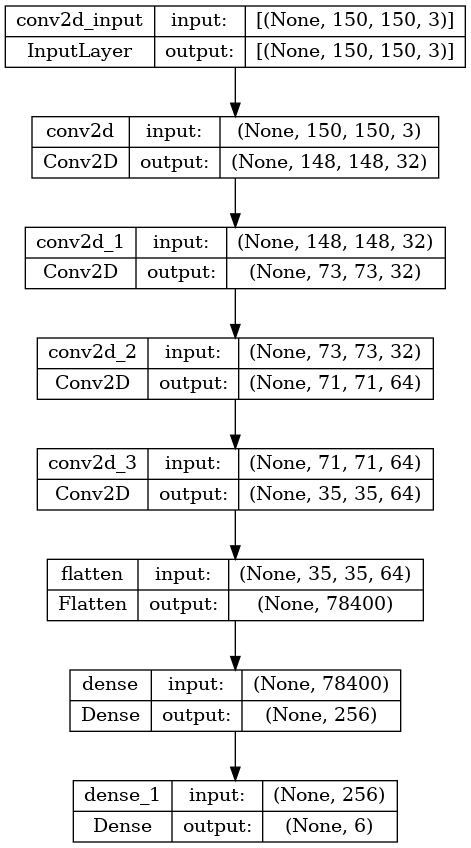

In [18]:
plot_model(model, to_file='model_plot_baseline.png', show_shapes=True, show_layer_names=True)

**Model Compilation and Fitting**

We set our optimizer as **Nadam**.

Much like Adam is essentially RMSprop with momentum, Nadam is Adam with Nesterov momentum.

Read more here - https://keras.io/api/optimizers/Nadam/

In [19]:
model.compile(optimizer = 'Nadam', loss = "categorical_crossentropy", metrics=["accuracy"])

In [20]:
history_baseline = model.fit_generator(
        train_generator,
        steps_per_epoch=len(train_generator),
        epochs=number_of_epochs, validation_data = val_generator, callbacks = [lr_scheduler])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.




Epoch 1: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 1/10
110/110 [==============================] - 93s 714ms/step - loss: 9.4978 - accuracy: 0.5420 - val_loss: 0.8919 - val_accuracy: 0.6580 - lr: 9.0484e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 2/10
110/110 [==============================] - 34s 312ms/step - loss: 0.6447 - accuracy: 0.7671 - val_loss: 0.8098 - val_accuracy: 0.7007 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 3/10
110/110 [==============================] - 36s 330ms/step - loss: 0.2810 - accuracy: 0.9076 - val_loss: 0.9353 - val_accuracy: 0.6877 - lr: 9.0484e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 4/10
110/110 [==============================] - 36s 327ms/step - loss: 0.0999 - accuracy: 0.9745 - val_loss: 1.1636 - val_accuracy: 0.7007 - lr: 8.1873e-04

Epoch 5: LearningRateScheduler 

**Baseline Model Performance Plot**

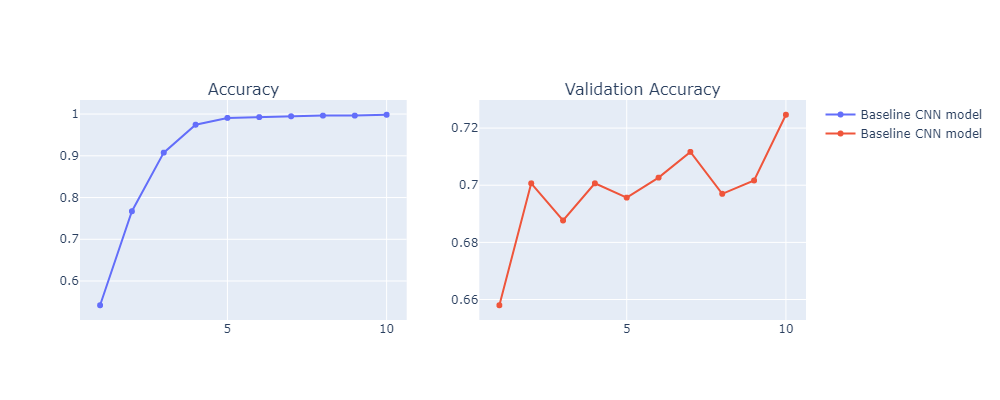

In [21]:
fig = graph_accuracy(history_baseline, number_of_epochs, model_name = "Baseline CNN model", create_new_graph = True)

# Transfer Learning Models

We make use of the "**tf.keras.applications**" so that Keras Applications are premade architectures with pre-trained weights.

Here is the documentation - https://www.tensorflow.org/api_docs/python/tf/keras/applications


**We use the following Transfer Learning Models -** 


*   ResNet50
*   Inception V3
*   MobileNet V3
*   VGG16

---

For almost all of transfer learning you will hear the following phrase "**Freezing and Unfreezing Layers**".

**What does that mean ?**

Transfer learning consists of taking features learned on one problem, and leveraging them on a new, similar problem. For instance, features from a model that has learned to identify racoons may be useful to kick-start a model meant to identify tanukis.

Transfer learning is usually done for tasks where your dataset has too little data to train a full-scale model from scratch.

The most common incarnation of transfer learning in the context of deep learning is the following workflow:

1. Take layers from a previously trained model.
2. Freeze them, so as to avoid destroying any of the information they contain during future training rounds.
3. Add some new, trainable layers on top of the frozen layers. They will learn to turn the old features into predictions on a new dataset.
4. Train the new layers on your dataset.

Link to reference - https://keras.io/guides/transfer_learning/


## ResNet 50 Model

Residual Network (ResNet) is a deep learning model used for computer vision applications. It is a Convolutional Neural Network (CNN) architecture designed to support hundreds or thousands of convolutional layers.

ResNet-50 is a convolutional neural network that is 50 layers deep. 

**Available configurations of ResNet -** Depending on your task you may use  ResNet-18, ResNet-34, ResNet-50, ResNet-101, ResNet-110, ResNet-152, ResNet-164, ResNet-1202, etc.

This particular model is trained on more than a million images from the ImageNet database.

Read more here - https://viso.ai/deep-learning/resnet-residual-neural-network/

---

**Model Architecure**

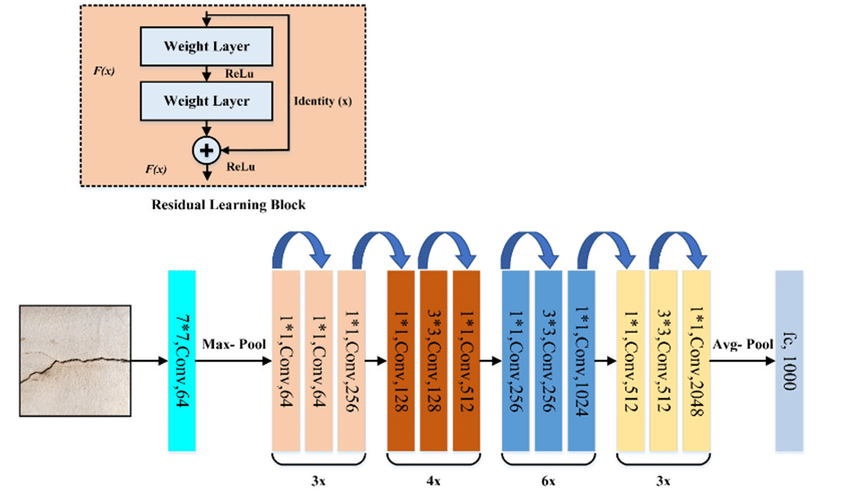

---
---

In [22]:
image_generator_resnet50 = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess_input)

It is advised to change the generator to a new one
where we add "**preprocessing_function=preprocess_input**" in the arguments so that this function changes the image to the format the module requires.

In [23]:
train_generator_resnet50 = image_generator_resnet50.flow_from_directory(
        train_path,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical')

Found 14034 images belonging to 6 classes.


In [24]:
val_generator_resnet50 = image_generator_resnet50.flow_from_directory(
        test_path,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical')

Found 3000 images belonging to 6 classes.



We now add our pre-trained model where **include_top = False** means that the don't include the pre-trained Dense classification layer so we can train one on our own.

Also note that **weights = 'imagenet'** means that we use weights from the imagenet competitions, however if you wish you could also load pre-trained weights from datasets on Kaggle.

Another thing to remember is that we set the previous layers to non-trainable.

In [25]:
model_resnet50 = tf.keras.Sequential()
model_resnet50.add(tf.keras.applications.ResNet50(include_top = False, pooling = 'avg', weights = 'imagenet'))
model_resnet50.add(tf.keras.layers.Dense(number_of_classes, activation = 'softmax'))
model_resnet50.layers[0].trainable = False

94765736/94765736 [==============================] - 0s 0us/step


**Model Summary**

A model summary is a very usefull method because be can better understand how the model works.

Summary also includes the amount of trainable and non-trainable parameters

We can also plot this summary to visualise the layers of the model.

In [26]:
model_resnet50.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 dense_2 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


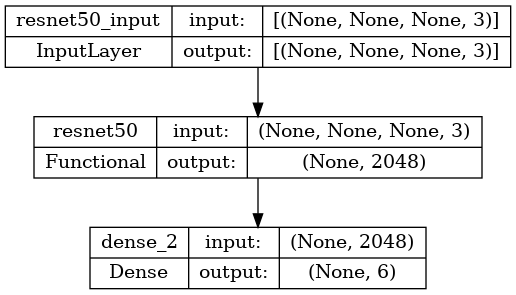

In [27]:
plot_model(model_resnet50, to_file='model_plot_resnet50.png', show_shapes=True, show_layer_names=True)

**Model Compilation and Fitting**

In [28]:
model_resnet50.compile(optimizer = 'Nadam', loss = "categorical_crossentropy", metrics=["accuracy"])
history_resnet50 = model_resnet50.fit_generator(
        train_generator_resnet50,
        steps_per_epoch=len(train_generator_resnet50),
        epochs=number_of_epochs, validation_data = val_generator_resnet50, callbacks = [lr_scheduler])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.




Epoch 1: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 1/10
110/110 [==============================] - 52s 425ms/step - loss: 0.4605 - accuracy: 0.8319 - val_loss: 0.2430 - val_accuracy: 0.9107 - lr: 9.0484e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 2/10
110/110 [==============================] - 43s 386ms/step - loss: 0.2141 - accuracy: 0.9225 - val_loss: 0.2162 - val_accuracy: 0.9227 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 3/10
110/110 [==============================] - 46s 419ms/step - loss: 0.1820 - accuracy: 0.9359 - val_loss: 0.2084 - val_accuracy: 0.9240 - lr: 9.0484e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 4/10
110/110 [==============================] - 43s 385ms/step - loss: 0.1610 - accuracy: 0.9443 - val_loss: 0.1979 - val_accuracy: 0.9273 - lr: 8.1873e-04

Epoch 5: LearningRateScheduler 

**Model Performance Plot**

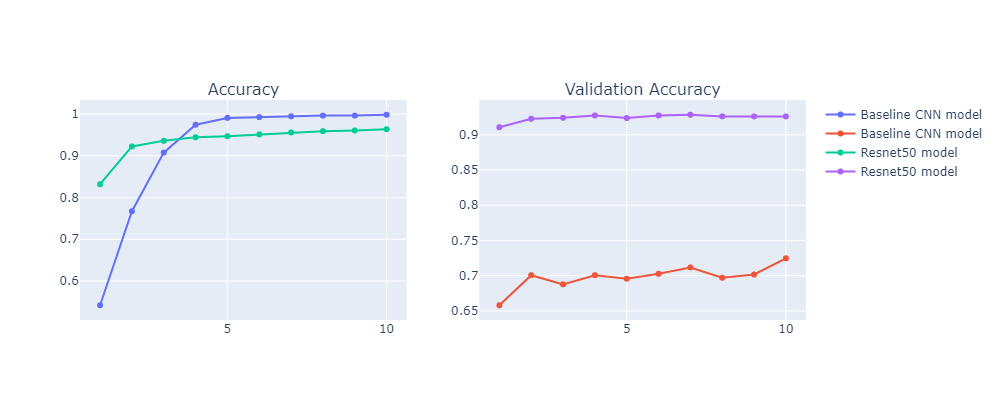

In [29]:
fig = graph_accuracy(history_resnet50, number_of_epochs, model_name = "Resnet50 model", fig = fig, create_new_graph = False)

## Inception V3 Model

Inception v3 is a convolutional neural network for assisting in image analysis and object detection, and got its start as a module for GoogLeNet. It is the third edition of Google's Inception Convolutional Neural Network, originally introduced during the ImageNet Recognition Challenge.

This CNN is **48 layers deep.**

Read more about it - https://cloud.google.com/tpu/docs/inception-v3-advanced#:~:text=Inception%20v3%20is%20an%20image,multiple%20researchers%20over%20the%20years.

---

Again we use the model pre-trained on the ImageNet database.

---

**Model Architecture**

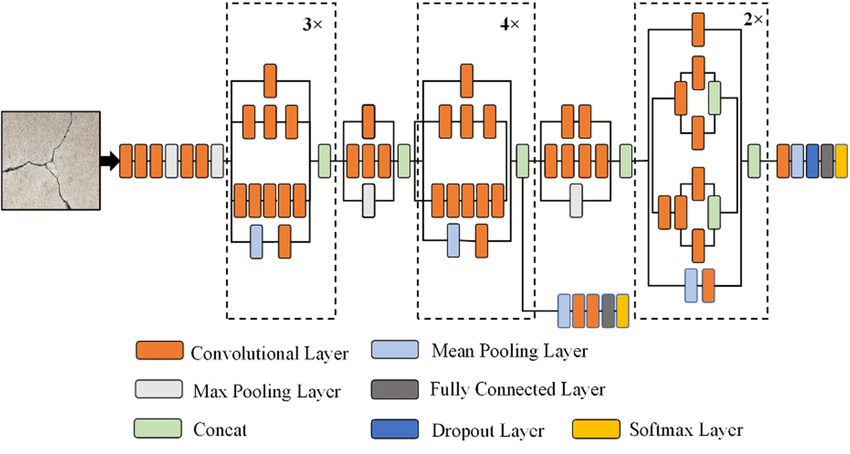

---
---


In [30]:
model_incv3 = tf.keras.Sequential()
model_incv3.add(tf.keras.applications.inception_v3.InceptionV3(include_top = False, pooling = 'avg', weights = 'imagenet'))
model_incv3.add(tf.keras.layers.Dense(number_of_classes, activation = 'softmax'))
model_incv3.layers[0].trainable = False

87910968/87910968 [==============================] - 0s 0us/step


**Model Summary**

In [31]:
model_incv3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 2048)              21802784  
                                                                 
 dense_3 (Dense)             (None, 6)                 12294     
                                                                 
Total params: 21,815,078
Trainable params: 12,294
Non-trainable params: 21,802,784
_________________________________________________________________


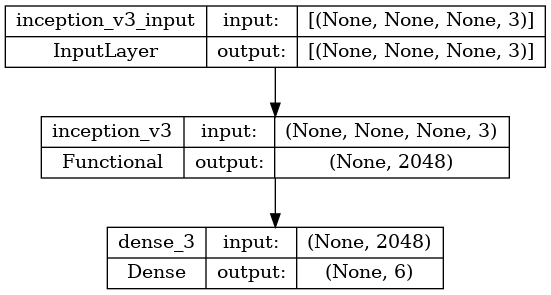

In [32]:
plot_model(model_incv3, to_file='model_plot_incv3.png', show_shapes=True, show_layer_names=True)

In [33]:
model_incv3.compile(optimizer = 'Nadam', loss = "categorical_crossentropy", metrics=["accuracy"])

In [34]:
image_generator_incv3 = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=pre_in_incv3)

As mentioned above we define a new data generator for this model.

In [35]:
train_generator_incv3 = image_generator_incv3.flow_from_directory(
        train_path,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical')

Found 14034 images belonging to 6 classes.


In [36]:
val_generator_incv3 = image_generator_incv3.flow_from_directory(
        test_path,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical')

Found 3000 images belonging to 6 classes.


In [37]:
history_incv3 = model_incv3.fit_generator(
        train_generator_incv3,
        steps_per_epoch=len(train_generator_incv3),
        epochs=number_of_epochs, validation_data = val_generator_incv3, callbacks = [lr_scheduler])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.




Epoch 1: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 1/10
110/110 [==============================] - 49s 387ms/step - loss: 0.6324 - accuracy: 0.7779 - val_loss: 0.3738 - val_accuracy: 0.8673 - lr: 9.0484e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 2/10
110/110 [==============================] - 38s 349ms/step - loss: 0.3266 - accuracy: 0.8869 - val_loss: 0.3204 - val_accuracy: 0.8857 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 3/10
110/110 [==============================] - 38s 347ms/step - loss: 0.2831 - accuracy: 0.9001 - val_loss: 0.3039 - val_accuracy: 0.8937 - lr: 9.0484e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 4/10
110/110 [==============================] - 38s 345ms/step - loss: 0.2569 - accuracy: 0.9106 - val_loss: 0.2958 - val_accuracy: 0.8930 - lr: 8.1873e-04

Epoch 5: LearningRateScheduler 

**Model Performance Plot**

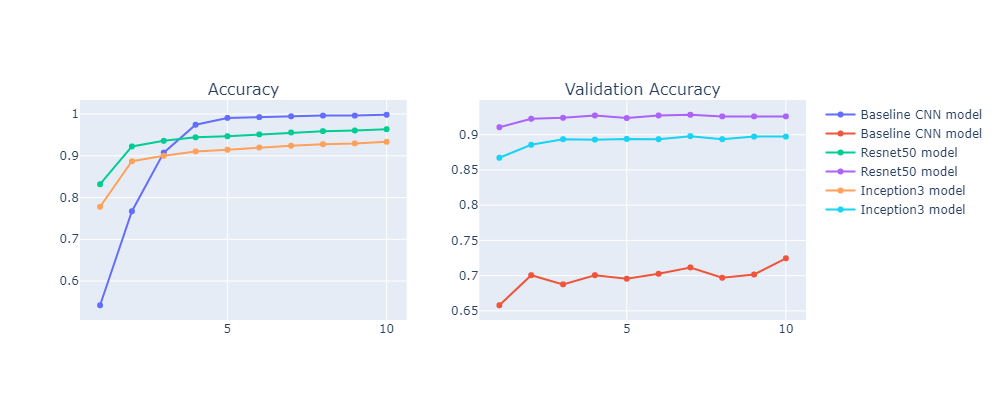

In [38]:
fig = graph_accuracy(history_incv3, number_of_epochs, model_name = "Inception3 model", fig = fig, create_new_graph = False)

## DenseNet

DenseNet (Dense Convolutional Network) has several advantages: they alleviate the vanishing-gradient, problem, strengthen feature propagation, encourage feature reuse, and substantially reduce the number of parameters.

DenseNet-169 was chosen because despite having a depth of 169 layers it is relatively low in parameters compared to other models, and the architecture handles the vanish gradient problem well.

The model is pre-trained on ImageNet database.

Read More - https://medium.com/@carlosz22/transfer-learning-using-keras-with-densenet-169-91679300f94a#:~:text=In%20the%20DenseNet%2D169%20architecture,final%20layer%20used%20ReLU%20activation.

---

**Model Architecture**

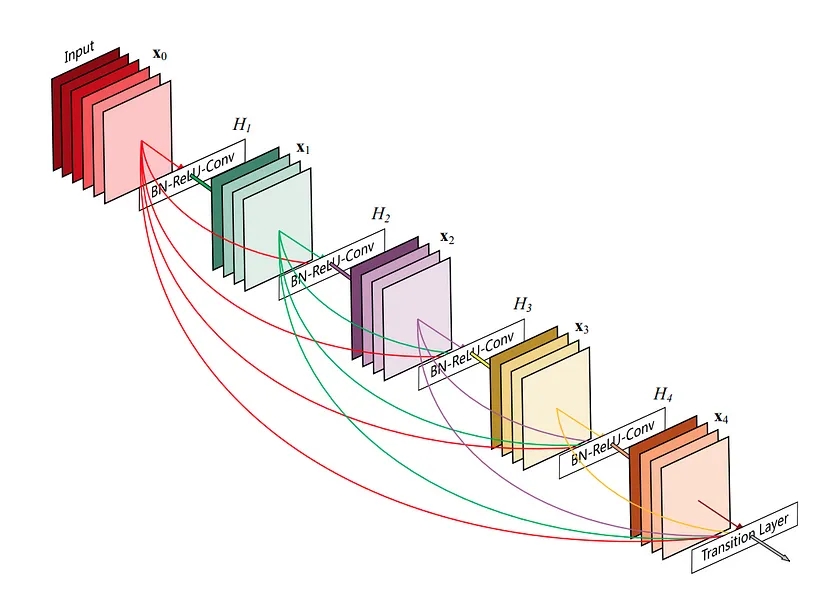

---
---

In [39]:
model_dne = tf.keras.Sequential()
model_dne.add(tf.keras.applications.densenet.DenseNet169(include_top = False, pooling = 'avg', weights = 'imagenet'))
model_dne.add(tf.keras.layers.Dense(number_of_classes, activation = 'softmax'))
model_dne.layers[0].trainable = False

51877672/51877672 [==============================] - 0s 0us/step


**Model Summary**

In [40]:
model_dne.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet169 (Functional)    (None, 1664)              12642880  
                                                                 
 dense_4 (Dense)             (None, 6)                 9990      
                                                                 
Total params: 12,652,870
Trainable params: 9,990
Non-trainable params: 12,642,880
_________________________________________________________________


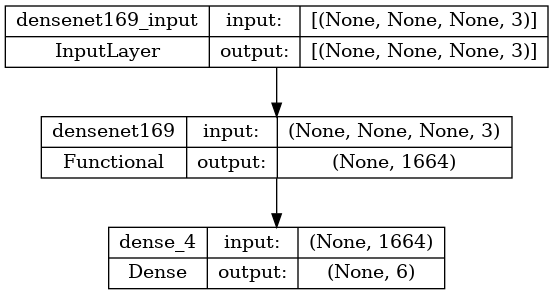

In [41]:
plot_model(model_dne, to_file='model_plot_dne.png', show_shapes=True, show_layer_names=True)

**Model Compilation and Fitting**

In [42]:
model_dne.compile(optimizer = 'Nadam', loss = "categorical_crossentropy", metrics=["accuracy"])

In [43]:
image_generator_dne = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=pre_in_dne)

In [44]:
train_generator_dne = image_generator_dne.flow_from_directory(
        train_path,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical')

Found 14034 images belonging to 6 classes.


In [45]:
val_generator_dne = image_generator_dne.flow_from_directory(
        test_path,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical')

Found 3000 images belonging to 6 classes.


In [46]:
history_dne = model_dne.fit_generator(
        train_generator_dne,
        steps_per_epoch=len(train_generator_dne),
        epochs=number_of_epochs, validation_data = val_generator_dne, callbacks = [lr_scheduler])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.




Epoch 1: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 1/10
110/110 [==============================] - 66s 479ms/step - loss: 0.5606 - accuracy: 0.8011 - val_loss: 0.2863 - val_accuracy: 0.9017 - lr: 9.0484e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 2/10
110/110 [==============================] - 45s 407ms/step - loss: 0.2492 - accuracy: 0.9131 - val_loss: 0.2467 - val_accuracy: 0.9080 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 3/10
110/110 [==============================] - 47s 428ms/step - loss: 0.2171 - accuracy: 0.9247 - val_loss: 0.2297 - val_accuracy: 0.9127 - lr: 9.0484e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 4/10
110/110 [==============================] - 44s 402ms/step - loss: 0.1986 - accuracy: 0.9298 - val_loss: 0.2230 - val_accuracy: 0.9173 - lr: 8.1873e-04

Epoch 5: LearningRateScheduler 

**Model Performance Plot**

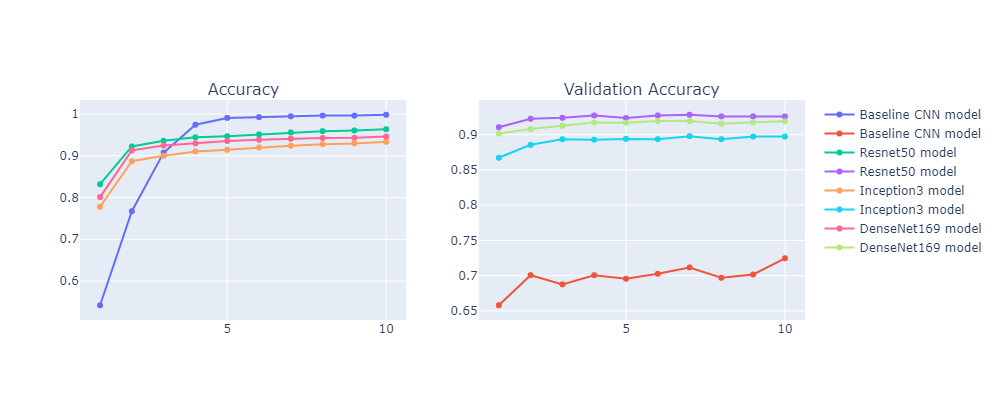

In [47]:
fig = graph_accuracy(history_dne, number_of_epochs, model_name = "DenseNet169 model", fig = fig, create_new_graph = False)

## VGG16 Model

VGG16 refers to the VGG(**Visual Geometry Group**) model, also called VGGNet. It is a convolution neural network (CNN) model supporting 16 layers. K. Simonyan and A. Zisserman from Oxford University proposed this model and published it in a paper called Very Deep Convolutional Networks for Large-Scale Image Recognition.

**Available Configurations -** Depending on your task you may use VGGNet-16, VGGNet-19, etc.

This model is trained on ImageNet database.

Read More Here - https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918

---

**Model Architecture**

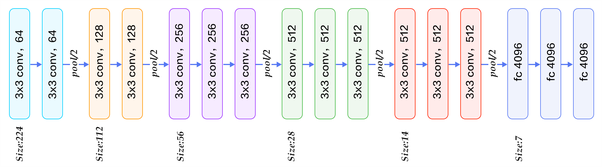

---
---

In [48]:
model_vgg = tf.keras.Sequential()
model_vgg.add(tf.keras.applications.vgg16.VGG16(include_top = False, pooling = 'avg', weights = 'imagenet'))
model_vgg.add(tf.keras.layers.Dense(number_of_classes, activation = 'softmax'))
model_vgg.layers[0].trainable = False

58889256/58889256 [==============================] - 0s 0us/step


In [49]:
model_vgg.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 512)               14714688  
                                                                 
 dense_5 (Dense)             (None, 6)                 3078      
                                                                 
Total params: 14,717,766
Trainable params: 3,078
Non-trainable params: 14,714,688
_________________________________________________________________


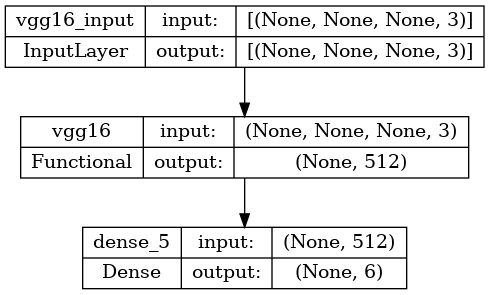

In [50]:
plot_model(model_vgg, to_file='model_plot_vgg.png', show_shapes=True, show_layer_names=True)

**Model Compilation and Fitting**

In [51]:
model_vgg.compile(optimizer = 'Nadam', loss = "categorical_crossentropy", metrics=["accuracy"])

In [52]:
image_generator_vgg = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=pre_in_vgg)

In [53]:
train_generator_vgg = image_generator_vgg.flow_from_directory(
        train_path,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical')

Found 14034 images belonging to 6 classes.


In [54]:
val_generator_vgg = image_generator_vgg.flow_from_directory(
        test_path,
        target_size=(image_size, image_size),
        batch_size=128,
        class_mode='categorical')

Found 3000 images belonging to 6 classes.


In [55]:
history_vgg = model_vgg.fit_generator(
        train_generator_vgg,
        steps_per_epoch=len(train_generator_vgg),
        epochs=number_of_epochs, validation_data = val_generator_vgg, callbacks = [lr_scheduler])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.




Epoch 1: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 1/10
110/110 [==============================] - 69s 527ms/step - loss: 1.8397 - accuracy: 0.6707 - val_loss: 0.8416 - val_accuracy: 0.8200 - lr: 9.0484e-04

Epoch 2: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 2/10
110/110 [==============================] - 45s 403ms/step - loss: 0.6109 - accuracy: 0.8554 - val_loss: 0.6032 - val_accuracy: 0.8683 - lr: 9.0484e-04

Epoch 3: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 3/10
110/110 [==============================] - 44s 400ms/step - loss: 0.4448 - accuracy: 0.8806 - val_loss: 0.5168 - val_accuracy: 0.8740 - lr: 9.0484e-04

Epoch 4: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 4/10
110/110 [==============================] - 47s 423ms/step - loss: 0.3609 - accuracy: 0.8972 - val_loss: 0.4657 - val_accuracy: 0.8807 - lr: 8.1873e-04

Epoch 5: LearningRateScheduler 

**Model Performance Plot**

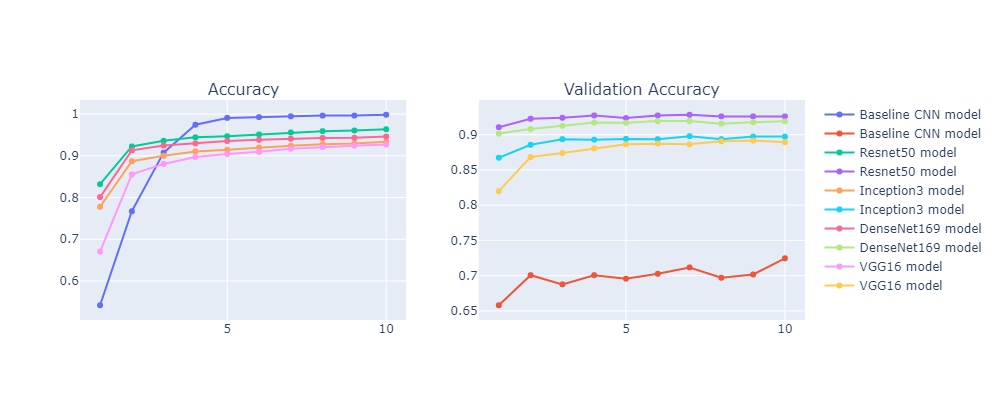

In [56]:
fig = graph_accuracy(history_vgg, number_of_epochs, model_name = "VGG16 model", fig = fig, create_new_graph = False)

# Conclusions

We have seen and understood what exactly is transfer learning.

Here's how our models ranked - 


1.   ResNet50
2.   DenseNet169
3.   Inception V3